In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds 

<pre> tf.keras.datasets vs tensorflow_datasets vs tf.data
  Tensorflow datasets is high level wrapper for tf.data, makes easy to load data
  use tf.data for custom dataset
  

##Images

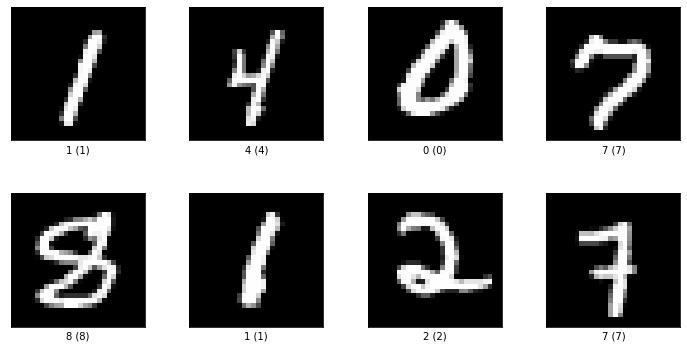

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.0,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



In [14]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist', # dataset name in tensorflow_dataset_catalog
    split=['train', 'test'], # can also have validation
    shuffle_files=True, # multiple tf.records of 1000
                        # even though these every 1000 intenally will be shuffled
                        # we also want ordering of files to shuffle to not see same
                        # order of files multiple times
    as_supervised=False,
    with_info=True,

)

fig = tfds.show_examples(ds_info, ds_train, rows=2, cols=4)
print(ds_info)

In [15]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist', # dataset name in tensorflow_dataset_catalog
    split=['train', 'test'], # can also have validation
    shuffle_files=True, # multiple tf.records of 1000
                        # even though these every 1000 intenally will be shuffled
                        # we also want ordering of files to shuffle to not see same
                        # order of files multiple times
    as_supervised=True,
    with_info=True,

)

In [17]:
def normalize_img(image, label):
  # normalize images
  return tf.cast(image, tf.float32)/255.0, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(64)
ds_train = ds_train.prefetch(AUTOTUNE)

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_test = ds_test.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(AUTOTUNE)

In [18]:
model = keras.Sequential(
    [
     keras.Input((28, 28, 1)),
     layers.Conv2D(32, 3, activation='relu'),
     layers.Flatten(),
     layers.Dense(10),
    ]
)

model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.fit(ds_train, epochs=10, verbose=2)

Epoch 1/10
938/938 - 4s - loss: 0.9258 - accuracy: 0.7774
Epoch 2/10
938/938 - 4s - loss: 0.3659 - accuracy: 0.8961
Epoch 3/10
938/938 - 4s - loss: 0.3232 - accuracy: 0.9065
Epoch 4/10
938/938 - 4s - loss: 0.3051 - accuracy: 0.9115
Epoch 5/10
938/938 - 4s - loss: 0.2927 - accuracy: 0.9161
Epoch 6/10
938/938 - 4s - loss: 0.2824 - accuracy: 0.9199
Epoch 7/10
938/938 - 4s - loss: 0.2745 - accuracy: 0.9223
Epoch 8/10
938/938 - 4s - loss: 0.2663 - accuracy: 0.9249
Epoch 9/10
938/938 - 4s - loss: 0.2592 - accuracy: 0.9275
Epoch 10/10
938/938 - 4s - loss: 0.2523 - accuracy: 0.9291


## Text

In [19]:
(ds_train, ds_test), ds_info = tfds.load(
    'imdb_reviews',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

print(ds_info)
for txt, label in ds_train:
  print(txt)
  print("=========")
  print(label)
  break

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteJ0EE5T/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteJ0EE5T/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteJ0EE5T/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew

In [21]:
tokenizer = tfds.features.text.Tokenizer()

def build_vocabulary():
  vocabulary = set()
  for text, _ in ds_train:
    vocabulary.update(tokenizer.tokenize(text.numpy().lower()))
  return vocabulary

vocabulary = build_vocabulary()
encoder = tfds.features.text.TokenTextEncoder(
    vocabulary, oov_token='<UNK>', lowercase=True, tokenizer=tokenizer
)
# use encoder to break sentence into words
# Lowercase the words
# Use vocabulary to turn words into indexes with oov_token for word not in vocabulary

In [23]:
def my_encoding(text_tensor, label):
  return encoder.encode(text_tensor.numpy()), label


def encode_map(text, label):
  # making encode function part of a graph
  encoded_text, label = tf.py_function(
      my_encoding, inp=[text, label], Tout=(tf.int64, tf.int64)
  )
  encoded_text.set_shape([None]) # arbitrary length
  label.set_shape([])  # single integer

  return encoded_text, label

AUTOTUNE = tf.data.experimental.AUTOTUNE

ds_train = ds_train.map(encode_map, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(10000)
ds_train = ds_train.padded_batch(32)
ds_train = ds_train.prefetch(AUTOTUNE)

ds_test = ds_test.map(encode_map)
ds_test = ds_test.padded_batch(32)

In [24]:
model = keras.Sequential(
    [
     layers.Masking(mask_value=0), # padding which are 0 by default
                                   # don't perform any computation on those
     layers.Embedding(input_dim=len(vocabulary)+2, output_dim=32),
     layers.GlobalAveragePooling1D(),
     layers.Dense(64, activation='relu'),
     layers.Dense(1)
    ]
)

model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(3e-4, clipnorm=1),
    metrics=['accuracy']
)

model.fit(ds_train, epochs=10, verbose=2)
model.evaluate(ds_test)

Epoch 1/10
782/782 - 28s - loss: 0.6770 - accuracy: 0.5034
Epoch 2/10
782/782 - 19s - loss: 0.5127 - accuracy: 0.7065
Epoch 3/10
782/782 - 19s - loss: 0.3519 - accuracy: 0.8519
Epoch 4/10
782/782 - 19s - loss: 0.2802 - accuracy: 0.8887
Epoch 5/10
782/782 - 19s - loss: 0.2385 - accuracy: 0.9090
Epoch 6/10
782/782 - 20s - loss: 0.2101 - accuracy: 0.9205
Epoch 7/10
782/782 - 19s - loss: 0.1867 - accuracy: 0.9318
Epoch 8/10
782/782 - 19s - loss: 0.1655 - accuracy: 0.9408
Epoch 9/10
782/782 - 19s - loss: 0.1486 - accuracy: 0.9479
Epoch 10/10
782/782 - 19s - loss: 0.1313 - accuracy: 0.9550
782/782 [==============================] - 21s 27ms/step - loss: 0.2858 - accuracy: 0.8876


[0.2858179211616516, 0.8876000046730042]